In [1]:
from functools import wraps
from datetime import datetime
import time
from toptica.lasersdk.dlcpro.v2_0_3 import DLCpro, NetworkConnection, DeviceNotFoundError, DecopError, UserLevel
import sys
import numpy as np
import threading
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import ipdb
import scipy.io as io
from copy import copy
from matplotlib.animation import FuncAnimation
import h5py
from nidaqmx.constants import AcquisitionType, TaskMode
import nidaqmx
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, Layout
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
from IPython.display import clear_output, display
import sys
try: 
    path = '/Users/greg/GoogleDrive/Work/ExperimentalSetup/PythonSoftware/InstrumentControl'
    if not path in sys.path:
        sys.path.insert(0, path) 
    from pyOSA import Yokogawa
#     from pyWavemeter import Wavemeter
# except Exception as err:
#     # path = r'Z:\\GoogleDrive\\Work\\ExperimentalSetup\\PythonSoftware\\InstrumentControl'
#     # if not path in sys.path:
#     #     sys.path.insert(0, path) 
#     # from pyOSA import Yokogawa
#     # from pyWavemeter import Wavemeter
except Exception as err: 
    print(err)
finally:
    %autosave 0 

No module named 'pyOSA'


Autosave disabled


# Linear Traces

In [2]:
from copy import copy
def SetupWideScan(ip = '169.254.122.1', lbd_scan = [1020.0, 1070.0],
                 duration = 8, factor = 10, positive = False, normalmode = False):
    with DLCpro(NetworkConnection(ip)) as dlc:
        dlc.laser1.wide_scan.output_channel.set(79)
        #setup recorder
        dlc.laser1.wide_scan.scan_begin.set(float(lbd_scan[0]))
        time.sleep(0.1)
        dlc.laser1.wide_scan.scan_end.set(float(lbd_scan[1]))
        dlc.laser1.ctl.remote_control.enabled.set(False)
        dlc.laser1.recorder.recording_time.set(5e6)
        time.sleep(0.1)
        dlc.laser1.recorder.sample_count_set.set(int(5e6))
        time.sleep(0.1)
        Npts = dlc.laser1.recorder.sample_count.get()
        
        step = 0.000000001
        dlc.laser1.wide_scan.recorder_stepsize_set.set(step)
        dlc.laser1.wide_scan.shape.set(0)
        time.sleep(0.1)
        dlc.laser1.ctl.wavelength_set.set((lbd_scan[0]+lbd_scan[1])/2)
        cnt = 0
        time.sleep(5)
        scan_width = lbd_scan[1]-lbd_scan[0]
        speed = 0.1*scan_width/duration
        time.sleep(0.1)
        # dlc.laser1.wide_scan.output_channel.set(20)
        # dlc.laser1.ctl.remote_control.signal.set(1)
        # dlc.laser1.ctl.remote_control.factor.set(float(factor))
        # dlc.laser1.ctl.remote_control.enabled.set(True)    
        # Amplitude = scan_width/factor
        # dlc.laser1.wide_scan.scan_begin.set(-Amplitude/2)
        # dlc.laser1.wide_scan.scan_end.set(Amplitude/2)
        # time.sleep(0.1)
        # dlc.laser1.wide_scan.speed.set(float(speed))
        # dlc.laser1.wide_scan.duration.set(float(duration))
        # if positive: 
        #     dlc.laser1.wide_scan.value_set.set(+Amplitude/2)
        # else:
        #     dlc.laser1.wide_scan.value_set.set(-Amplitude/2)
        # time.sleep(10)
        # scan = [dlc.laser1.wide_scan.scan_begin.get(),
        #         dlc.laser1.wide_scan.scan_end.get()]
#         print('Scan limits: {}'.format(scan))

def LaunchScan(ip = '169.254.122.1'):
    with DLCpro(NetworkConnection(ip)) as dlc:
        dlc.laser1.wide_scan.start()
        
def GetScan(ip = '169.254.122.1',
            lbd_scan = [1020.0, 1070.0], duration = 60, clk = 1e5, 
            dev = 'Dev1', ch = ['ai0','ai23', 'ai6'], 
           factor = 10):
    system = nidaqmx.system.System.local()
    device = system.devices[dev]
    device.reset_device()
    Npts = (duration+5)*clk
    print('Sampling Points = {}'.format(Npts))
    readtask = nidaqmx.Task()
    ch = dev + '/' +  ',{}/'.format(dev).join(ch)
    readtask.ai_channels.add_ai_voltage_chan(ch,min_val=-5, max_val=10)
    readtask.timing.cfg_samp_clk_timing(clk, sample_mode=AcquisitionType.CONTINUOUS,samps_per_chan=int(Npts))
    readtask.start()
    time.sleep(1)
    LaunchScan(ip = ip)
    time.time()
#     time.sleep(duration)
    start = time.time()
    new = copy(start)
    while time.time()-start<=duration:
        if time.time()-new >= 1:
            clear_output(wait=True)
            print('Remaining time: {:.1f} s'.format(duration - (time.time()-start)), end = '\r')
            new = time.time()
    data =[]
    data += readtask.read(number_of_samples_per_channel=int(Npts))
    print('*'*30)
    print('Got DAQ data')
    readtask.stop()
    readtask.close()
    data = np.array(data)
    data = np.array(data)
    with DLCpro(NetworkConnection(ip)) as dlc:
        dlc.laser1.ctl.remote_control.enabled.set(False)
        dlc.laser1.wide_scan.output_channel.set(79)
    return pd.DataFrame({'S': data[0], 'MZ': data[1], 'V': data[2], 'lbd_start': lbd_scan[0], 'lbd_stop':lbd_scan[1], 'factor': factor})

def BackToNormal(ip = '169.254.122.1', lbd_scan = [1020.0, 1070.0]):
    with DLCpro(NetworkConnection(ip)) as dlc:
        dlc.laser1.ctl.remote_control.enabled.set(False)
        dlc.laser1.wide_scan.output_channel.set(79)
        dlc.laser1.ctl.wavelength_set.set((lbd_scan[0]+lbd_scan[1])/2)
        
def GetWavemeter(wlm, chanel=1):
    wlm.pulsemode = False
    wlm.widemode = False
    wlm.fastmode = False
    wlm.channel = chanel
    wlm.exposure = 'auto'
    wlm.acquire = True
    time.sleep(1)
    lbd = wlm.lbd
    wlm.acquire = False
    return lbd

In [ ]:
wavemeter = Wavemeter()
wavemeter.connected = 'show'

In [4]:
import gc
import time
import winsound
gc.collect()


duration = 60
laser  = 1060
WithWavemeter = False


if laser == 1060:
    ldb_scan = [1050.0, 1070.0]
    ip = '10.0.0.7'
    factor = 6.25
elif laser == 1550:
    ldb_scan = [1510.0, 1630.0]
    ip = '10.0.0.8'
    factor = 15
clk  = 0.75e6
ch = ['ai0','ai2', 'ai3']

#-------------------
#-------------------
SetupWideScan(ip = ip, duration=duration, lbd_scan = ldb_scan, positive = False, factor = factor)

if WithWavemeter:
    time.sleep(10)
    lbd_start = GetWavemeter(wavemeter, chanel=1)
    print('lbd_start = {:.4f}'.format(lbd_start))

# df = GetScan(ip = ip, lbd_scan = ldb_scan, duration = duration, dev = 'cDAQ1Mod1', ch = ch, clk=clk)

# if WithWavemeter:
#     time.sleep(1)
#     SetupWideScan(ip = ip, duration=duration, lbd_scan = ldb_scan, positive = True)
#     time.sleep(10)
#     lbd_stop = GetWavemeter(wavemeter, chanel=1)
#     print('lbd_stop = {:.4f}'.format(lbd_stop))

#     # -------------------
#     time.sleep(1)
#     BackToNormal(ip = ip, lbd_scan = ldb_scan)
#     df.lbd_stop = lbd_stop
#     df.lbd_start = lbd_start
#     # -------------------

# #-------------------
# #-------------------
# time.sleep(1)
# gc.collect()



# tr = [go.Scatter(y = df.S.values[::100] ,name = 'S')]
# tr += [go.Scatter(y = df.MZ.values[::100] ,name = 'MZ')]
# tr += [go.Scatter(y = df.V.values[::100] ,name = 'V')]
# iplot(go.Figure(data = tr))


#---------------------------------------------------------------------------------------------

 


In [292]:

#---------------------------------------------------------------------------------------------

import os
import pandas as pd

RW = [1080, 1088, 1095, 1103, 1110, 1117, 1125, 1133, 1140]
Lc = [9, 10, 11, 12, 13, 14]

RW = 1140
G = 340
Lc = 12


# G2 = 200


path = 'G:/My Drive/Work/Characterization/NIST/Others/2020-06-AuxPump/Data/DODOS/Chip28/W2F0/07282020/Linear1550/Pol1/'
fname = 'RW{}G{}Lc{}'.format(RW, G, Lc)

print('Parameters: ')
print('\t- RW\t=\t{}nm'.format(RW))
print('\t- G\t=\t{}nm'.format(G))
print('\t- Lc\t=\t{}µm'.format(Lc))
# print('\t- Gdrop\t=\t{}nm'.format(G2))
print('')

if os.path.exists('{}{}.parquet'.format(path, fname)):
    print('FILE ALREADY EXIST!!!!')
else:
    print('Saving file : {}{}.parquet'.format(path, fname))
    df.to_parquet('{}{}.parquet'.format(path, fname))
    
winsound.PlaySound("*", winsound.SND_ALIAS)



Parameters: 
	- RW	=	1080nm
	- G	=	280nm
	- Lc	=	11µm

Saving file : G:/My Drive/Work/Characterization/NIST/Others/2020-06-AuxPump/Data/DODOS/Chip28/W2F0/07282020/Linear1550/Pol1/RW1080G280Lc11.parquet


# Comb

In [ ]:
osa = Yokogawa(ip='169.254.122.25')
osa.connected = True

In [79]:
lbd_start  = 600
lbd_stop = 1550

para = osa.settings
para['resol'] = 1
para['centwlgth'] = 0.5e-9*(lbd_start+lbd_stop)
para['span'] = 1e-9*(lbd_stop - lbd_start)
para['bdwdth'] = 1e-9
osa.settings = para
osa.scan = 'repeat'

In [76]:
lbd_start  = 600
lbd_stop = 1550

para = osa.settings
para['resol'] = 3
para['centwlgth'] = 0.5e-9*(lbd_start+lbd_stop)
para['span'] = 1e-9*(lbd_stop - lbd_start)
para['bdwdth'] = 0.5e-9
osa.settings = para
osa.scan = 'repeat'

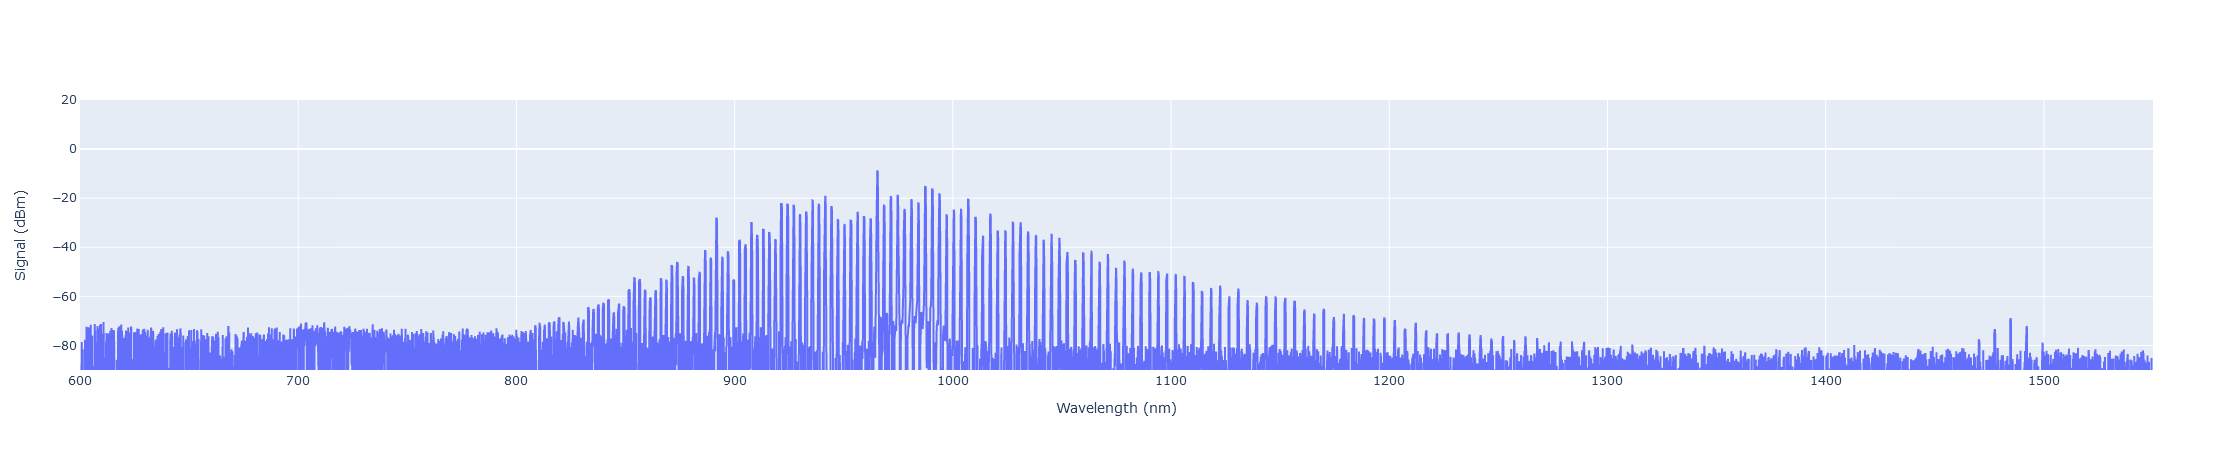

In [77]:
osa.scan = 'stop'
osa.trace = 'TRA'
_ = osa.PlotlyTrace(ylim = [-90, 20])

In [78]:
trace = osa.trace

# ------------
RW = 920
G = 200
Lc = 18
G2 = 200
# ------------
Pin = 436
Pout = 51
Att = 0 
lbd_pmp = 964.670
port = 'Drop'
# ------------

path = './2019-12-Mask5_run2/Data/Chip1/Combs/SecondTrim/980nmPump/AddDrop/'
# fname = 'RW{}G{}Gdrop{}'.format(RW, G, G2)
# fname = 'RW{}G{}Lc{}Gdrop{}_MI_Pin{}'.format(RW,G,Lc, G2, Pin)
fname = 'RW{}Lc{}G{}G2{}_Port{}_MI_Pin{}Lbd{:.3f}'.format(RW,Lc,G, G2,port, Pin, lbd_pmp)


print('Parameters: ')
print('\t- RW\t=\t{}nm'.format(RW))
print('\t- G\t=\t{}nm'.format(G))
print('\t- Lc\t=\t{}µm'.format(Lc))
print('\t- Gdrop\t=\t{}nm'.format(G2))
print('')

if os.path.exists('{}{}.parquet'.format(path, fname)):
    print('FILE ALREADY EXIST!!!!')
else:
    print('Saving file : {}{}.parquet'.format(path, fname))
    trace['Pin'] = Pin
    trace['Pout'] = Pout
    trace['Att'] = Att
    trace['lbd_pmp'] = lbd_pmp
    trace.to_parquet('{}{}.parquet'.format(path, fname))

Parameters: 
	- RW	=	920nm
	- G	=	200nm
	- Lc	=	18µm
	- Gdrop	=	200nm

Saving file : ./2019-12-Mask5_run2/Data/Chip1/Combs/SecondTrim/980nmPump/AddDrop/RW920Lc18G200G2200_PortDrop_MI_Pin436Lbd964.670.parquet


4984